In [1]:
import pytorch_model_summary as tms
import os
import torch
import argparse
import itertools
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torchvision.utils import save_image
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import get_rank, init_process_group, destroy_process_group, all_gather, get_world_size
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torch.utils.data.distributed import DistributedSampler
import random
from customDiffusion.unet import Unet
from customDiffusion.embedding import ConditionalEmbedding
from customDiffusion.utils import get_named_beta_schedule
from customDiffusion.diffusion import GaussianDiffusion
from customDiffusion.Scheduler import GradualWarmupScheduler
from PIL import Image
import torchvision
import torch.nn as nn
from RealESRGAN import RealESRGAN
print(f"GPUs used:\t{torch.cuda.device_count()}")

device = torch.device("cuda", 5)
print(f"Device:\t\t{device}")
start_epc = 130
model_path = '../../model/conditionDiff/custom_detail1/BRIL/ckpt_130_checkpoint.pt'


GPUs used:	8
Device:		cuda:5


In [18]:
def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")


class_list = ['유형8', '유형9']
params = {'image_size': 512,
          'lr': 2e-5,
          'beta1': 0.5,
          'beta2': 0.999,
          'batch_size': 2,
          'epochs': 1000,
          'n_classes': None,
          'data_path': '../../data/normalization_type/BRIL/',
          'image_count': 5000,
          'inch': 3,
          'modch': 128,
          'outch': 3,
          'chmul': [1,2, 4, 8],
          'numres': 4,
          'dtype': torch.float32,
          'cdim': 256,
          'useconv': False,
          'droprate': 0.1,
          'T': 1000,
          'w': 1.8,
          'v': 0.3,
          'multiplier': 1,
          'threshold': 0.02,
          'ddim': True,
          }
tf = transforms.ToTensor()

def transback(data:Tensor) -> Tensor:
        data=data-data.min()
        data=data/data.max()

        return data


In [20]:



class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


Generator = Generator(3, 3).to(device)
Generator.load_state_dict(torch.load(
    '../../model/cyclegan/G_B_29.pth', map_location=device))
SR_model= RealESRGAN(device, scale=2).model.to(device)
SR_model.load_state_dict(torch.load(
    '../../model/ESRGAN/ckpt_163_checkpoint.pt', map_location=device))

<All keys matched successfully>

In [4]:

net = Unet(in_ch=params['inch'],
           mod_ch=params['modch'],
           out_ch=params['outch'],
           ch_mul=params['chmul'],
           num_res_blocks=params['numres'],
           cdim=params['cdim'],
           use_conv=params['useconv'],
           droprate=params['droprate'],
           dtype=params['dtype']
           ).to(device)
cemblayer = ConditionalEmbedding(
    len(class_list), params['cdim'], params['cdim']).to(device)
betas = get_named_beta_schedule(num_diffusion_timesteps=params['T'])
diffusion = GaussianDiffusion(
    dtype=params['dtype'],
    model=net,
    betas=betas,
    w=params['w'],
    v=params['v'],
    device=device
)
optimizer = torch.optim.AdamW(
    itertools.chain(
        diffusion.model.parameters(),
        cemblayer.parameters()
    ),
    lr=params['lr'],
    weight_decay=1e-6
)


cosineScheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
warmUpScheduler = GradualWarmupScheduler(
    optimizer=optimizer,
    multiplier=params['multiplier'],
    warm_epoch=30,
    after_scheduler=cosineScheduler,
    last_epoch=0
)
checkpoint = torch.load(model_path, map_location=device)
diffusion.model.load_state_dict(checkpoint['net'])
cemblayer.load_state_dict(checkpoint['cemblayer'])
optimizer.load_state_dict(checkpoint['optimizer'])
warmUpScheduler.load_state_dict(checkpoint['scheduler'])

In [5]:
topilimage = torchvision.transforms.ToPILImage()
diffusion.model.eval()
cemblayer.eval()
# generating samples
# The model generate 80 pictures(8 per row) each time
# pictures of same row belong to the same class
all_samples = []
each_device_batch = len(class_list)
with torch.no_grad():
    lab = torch.ones(len(class_list), each_device_batch // len(class_list)).type(torch.long) \
        * torch.arange(start=0, end=len(class_list)).reshape(-1, 1)
    lab = lab.reshape(-1, 1).squeeze()
    lab = lab.to(device)
    cemb = cemblayer(lab)
    genshape = (each_device_batch, params['outch'],
                params['image_size'], params['image_size'])
    if params['ddim']:
        generated = diffusion.ddim_sample(
            genshape, 50, 0.0, 'quadratic', cemb=cemb)
    else:
        generated = diffusion.sample(genshape, cemb=cemb)
    generated =transback(generated.to(device))
    for i in range(len(lab)):
        img_pil = topilimage(generated[i].cpu())

Start generating(ddim)...


100%|██████████| 50/50 [01:37<00:00,  1.96s/it]

ending sampling process(ddim)...


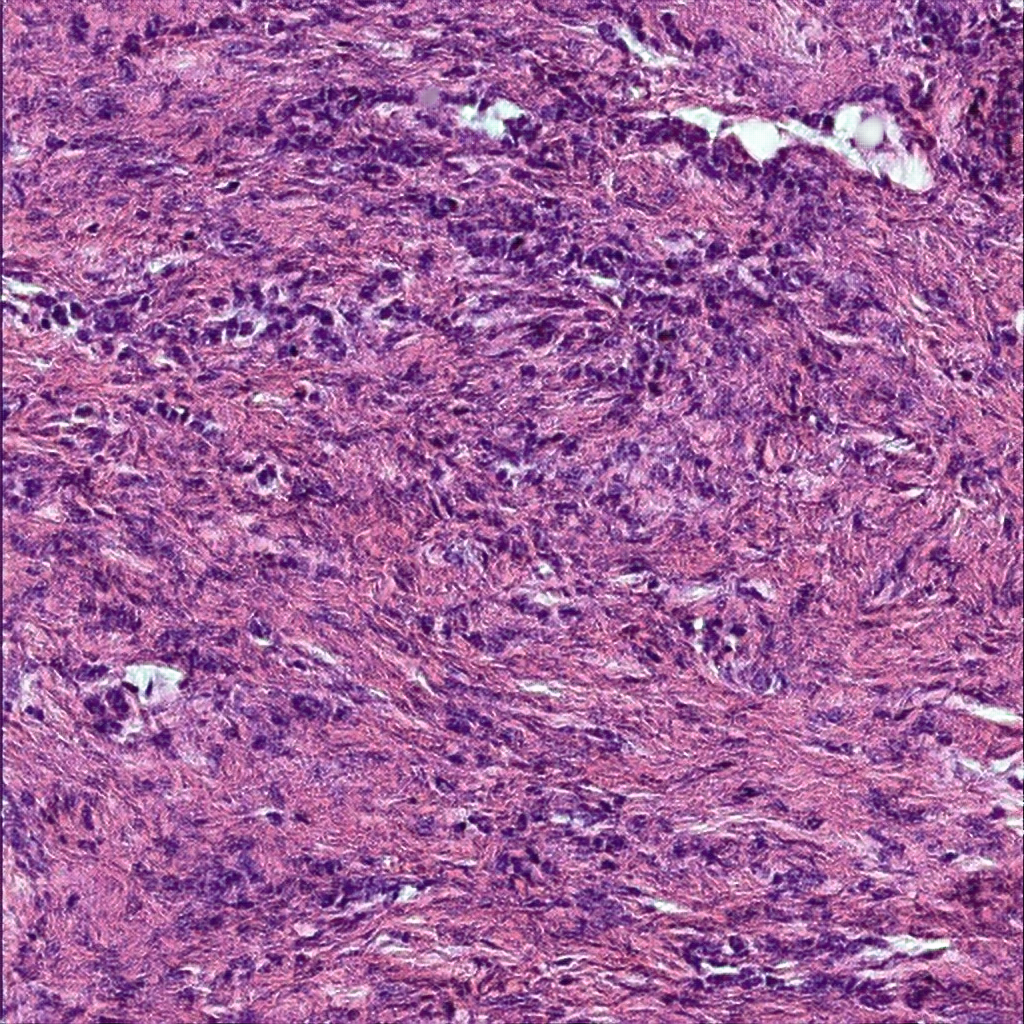

In [28]:
topilimage(transback(Generator(transback(SR_model(generated))*2-1))[0])

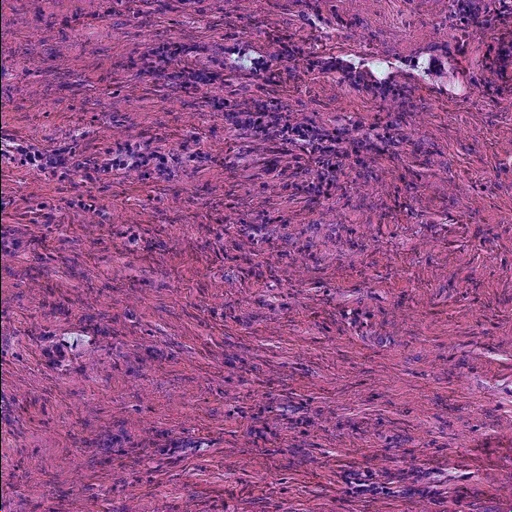

In [27]:
topilimage(generated[0])